In [1]:
library(rlang)
library(monocle3)
library(shiny)
library(ggplot2)
library(dplyr)
library(garnett)
library(Matrix)
library(irlba)
#library(monocle)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘Biobase’


The following object is masked from ‘package:rlang’:

    exprs


Loading required package: SingleCellExperiment

Loadin

In [2]:
setwd('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trajectory_with_Rik_model_output/')
sce <- readRDS('wave2_steroid_2021_covid_GPLVM.RDS') 


In [3]:
counts(sce) <- assays(sce)[['X']] 
sce

class: SingleCellExperiment 
dim: 32913 17256 
metadata(0):
assays(2): X counts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(1): GEX
colnames(17256): UK-CIC10690373+UK-CIC10690565_ACGGGCTTCCTTGCCA-1
  UK-CIC10690322+UK-CIC10690514_TGAGGGAAGATGCCTT-1 ...
  UK-CIC10690354+UK-CIC10690546_CAGGTGCAGTGCTGCC-1
  UK-CIC10690325+UK-CIC10690517_GTGGGTCTCGCGCCAA-1
colData names(31): annot4 centre ... time_from_positive_swab
  time_from_infection
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

# check for subsetting

In [4]:
unique(sce$annot4)

[1] HSPC                       Platelet                  
 [3] RBC                        CD14mono                  
 [5] CD16mono                   Int.mono                  
 [7] CD14mono_anti_inflammatory CD14mono_IFN              
 [9] CD14mono_activated         CD16mono_IFN              
[11] CD16mono_C1                DC3_IFN                   
[13] DC2                        pDC                       
[15] DC3                        DC1                       
[17] ASDC                      
17 Levels: ASDC CD14mono CD14mono_IFN ... pDC

In [5]:
unique(sce$centre)

[1] Cambridge
Levels: Cambridge

In [6]:
unique(sce$case_control)

[1] POSITIVE RECOVERY
Levels: POSITIVE RECOVERY

In [7]:
unique(sce$WHO_temp_severity)

[1] severe   moderate critical nan      mild    
Levels: critical mild moderate nan severe

In [8]:
unique(sce$individual_id)

[1] C101 C138 C147 C33  C146 C145
Levels: C101 C138 C145 C146 C147 C33

# create subset

In [9]:
sce <- sce[, sce$annot4 %in% c('CD14mono_anti_inflammatory','CD14mono','CD14mono_IFN','CD14mono_activated')]#only include CD14mono 
print(unique(sce$annot4))
sce

[1] CD14mono                   CD14mono_anti_inflammatory
[3] CD14mono_IFN               CD14mono_activated        
17 Levels: ASDC CD14mono CD14mono_IFN ... pDC


class: SingleCellExperiment 
dim: 32913 10632 
metadata(0):
assays(2): X counts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(1): GEX
colnames(10632): UK-CIC10690366+UK-CIC10690558_AACTTTCCAAGTCATC-1
  UK-CIC10690366+UK-CIC10690558_TATTACCAGAGTAATC-1 ...
  UK-CIC10690354+UK-CIC10690546_CAGGTGCAGTGCTGCC-1
  UK-CIC10690325+UK-CIC10690517_GTGGGTCTCGCGCCAA-1
colData names(31): annot4 centre ... time_from_positive_swab
  time_from_infection
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [11]:
sce$individual_id <- droplevels(sce$individual_id)
sce$sample_id <- droplevels(sce$sample_id)
sce$WHO_temp_severity <- droplevels(sce$WHO_temp_severity)
sce$annot4 <- droplevels(sce$annot4)
sce$centre <- droplevels(sce$centre)
sce$case_control <- droplevels(sce$case_control)
sce$orig.ident <- droplevels(sce$orig.ident)

In [12]:
expression_matrix <-counts(sce)
cell_metadata  <- colData(sce)
gene_annotation <- rowData(sce)

In [13]:
#creat cds
cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)

Warning message in new_cell_data_set(expression_matrix, cell_metadata = cell_metadata, :
“Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”


In [14]:
cds <- preprocess_cds(cds,num_dim = 50, method ="PCA")
cds <- align_cds(cds, alignment_group = "individual_id")


Aligning cells from different batches using Batchelor. 
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091



In [15]:
cds <- reduce_dimension(cds)#,reduction_method = 'UMAP')


No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



No trajectory to plot. Has learn_graph() been called yet?

No trajectory to plot. Has learn_graph() been called yet?



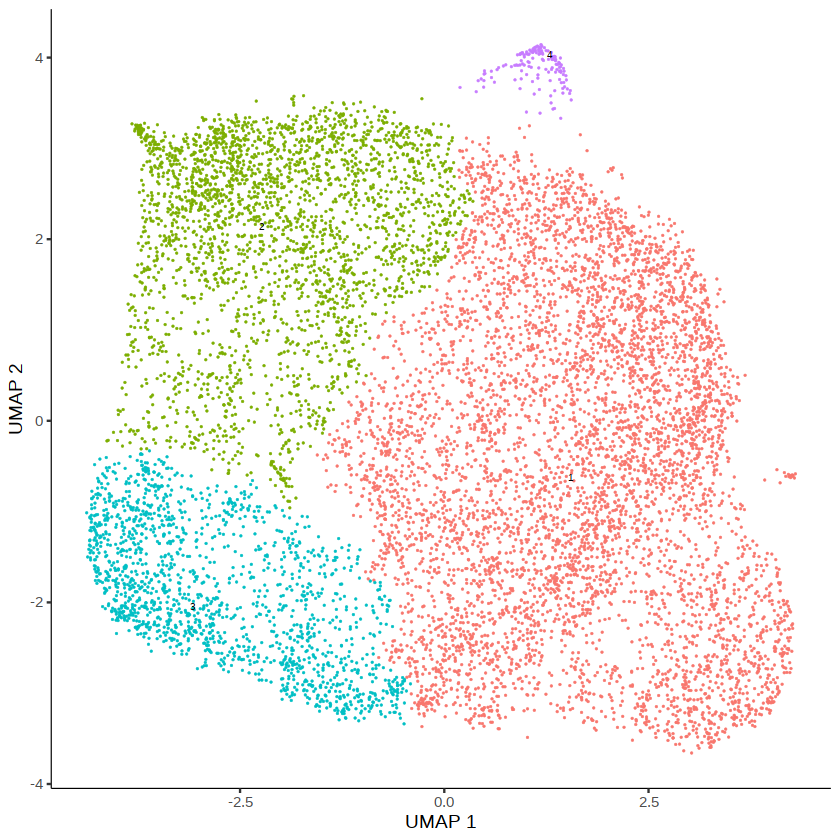

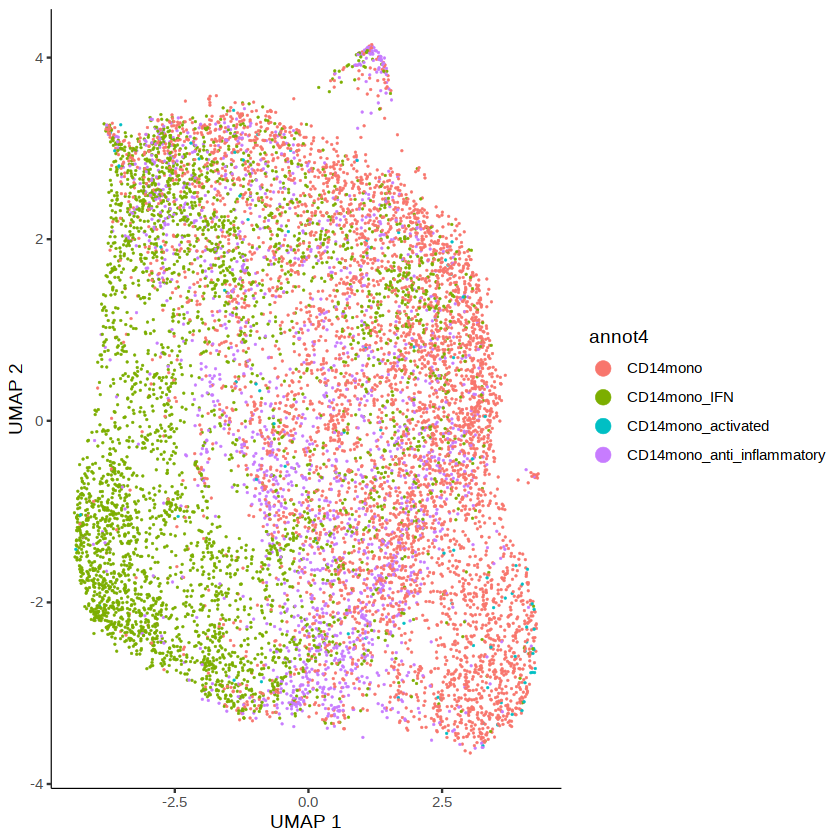

In [16]:
cds <- cluster_cells(cds, resolution=0.0001)
plot_cells(cds, color_cells_by = "cluster")
plot_cells(cds, color_cells_by = "annot4",label_cell_groups = FALSE)

In [17]:
cds <- learn_graph(cds, use_partition=FALSE, verbose = FALSE)

  |======================================================================| 100%


Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”


Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


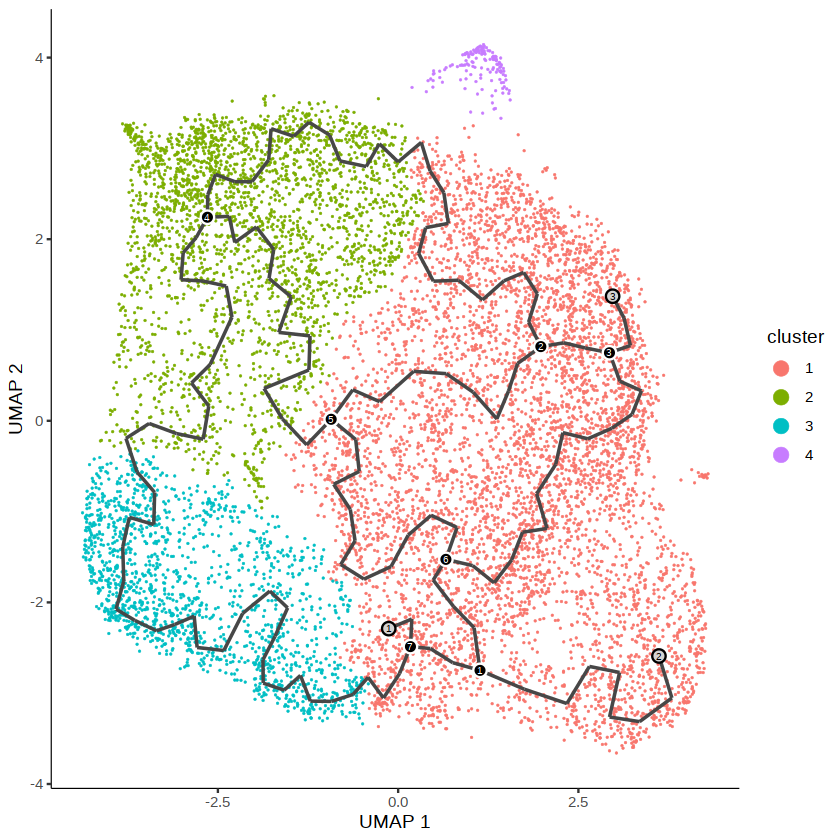

In [18]:
P1.1 <- plot_cells(cds, group_label_size = 5, label_cell_groups = FALSE)
P1.1


Cells aren't colored in a way that allows them to be grouped.



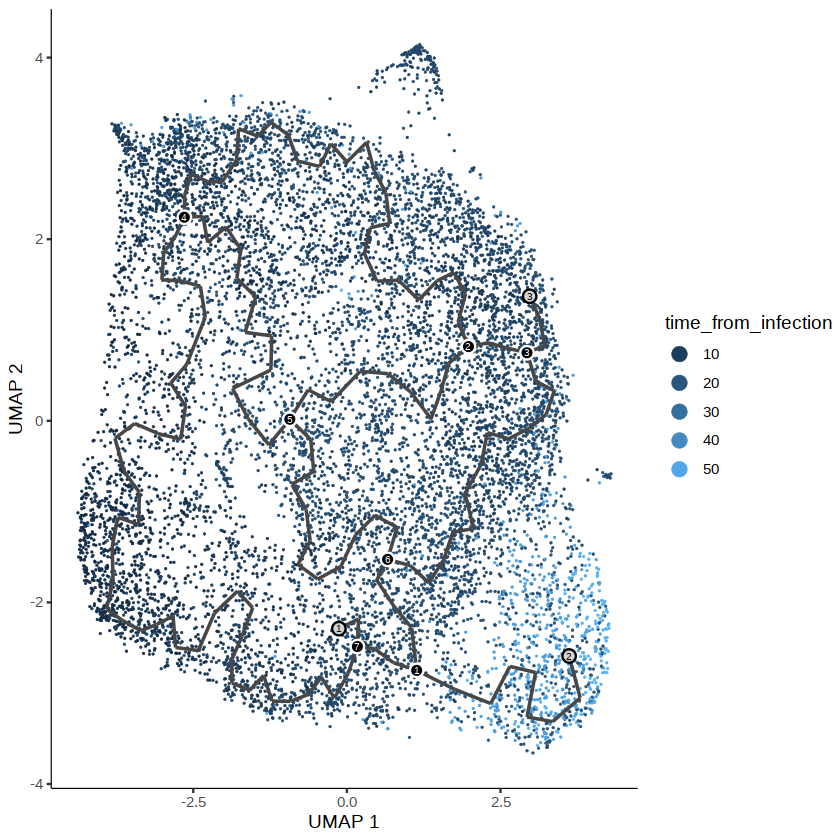

In [19]:
P1.2 <- plot_cells(cds, group_label_size = 5, color_cells_by = "time_from_infection", label_cell_groups = TRUE)
P1.2


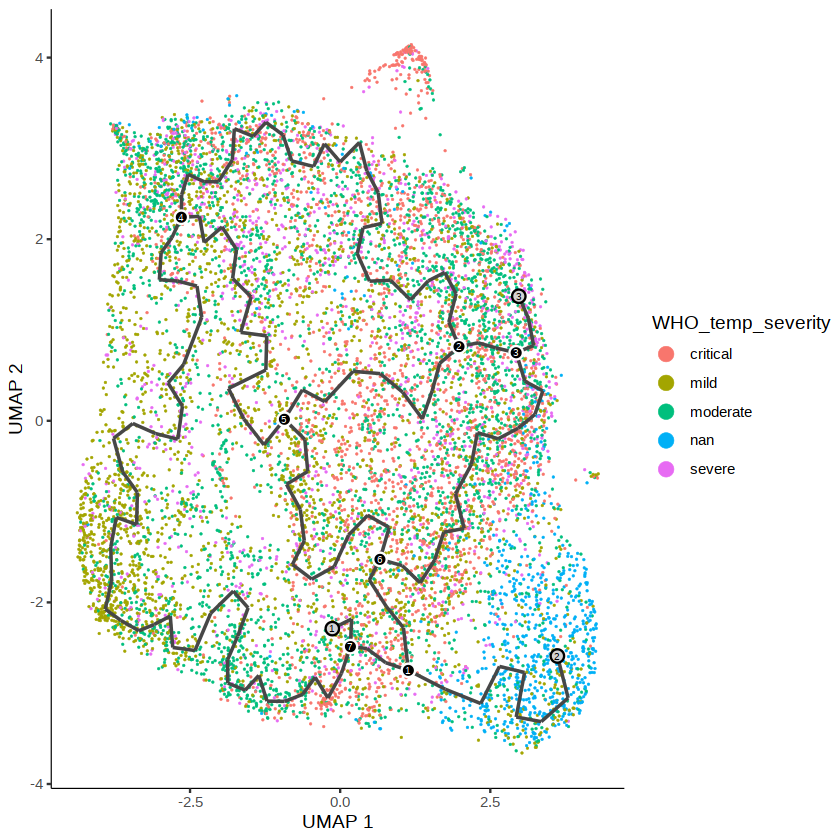

In [20]:
P1.3 <- plot_cells(cds, group_label_size = 5, color_cells_by = "WHO_temp_severity", label_cell_groups = FALSE)
P1.3


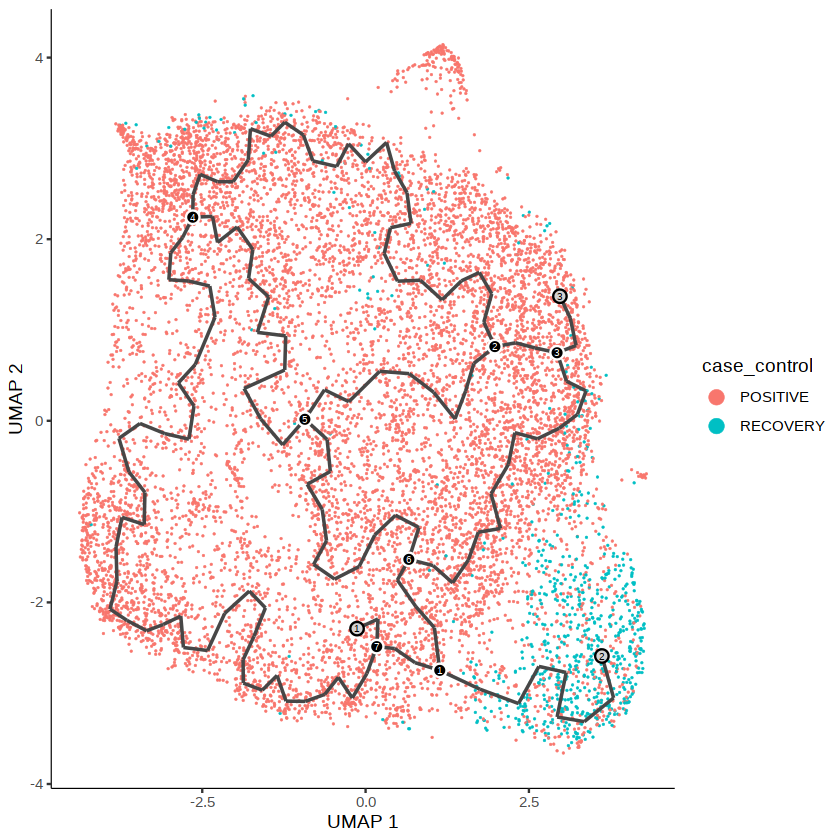

In [21]:
P1.4 <- plot_cells(cds, group_label_size = 5, color_cells_by = "case_control", label_cell_groups = FALSE)
P1.4


In [ ]:
#steps to plot gene 
#"C1QA" %in% row.names(rowData(cds)) # checking if gene present
rowData(cds)$gene_name <- rownames(cds)
rowData(cds)$gene_short_name <- rowData(cds)$gene_name
P1.3 <- plot_cells(cds, genes = c('CD14',
        'FCGR3A','C1QA','C1QB','C1QC','IFITM3','IFITM2'), show_trajectory_graph = FALSE)
P1.3



In [22]:
min(cds$pseudotime_GPLVM) # get the minimum pseudotime from GPLVM output for ordering

[1] -0.2515591

In [23]:
# a helper function to identify the root principal points: use the minimun pseudotime as starting point
get_earliest_principal_node <- function(cds, time_bin='-0.25155908'){
  cell_ids <- which(colData(cds)[, "pseudotime_GPLVM"] == time_bin)
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
  print(root_pr_nodes)
}

cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))

[1] "Y_72"


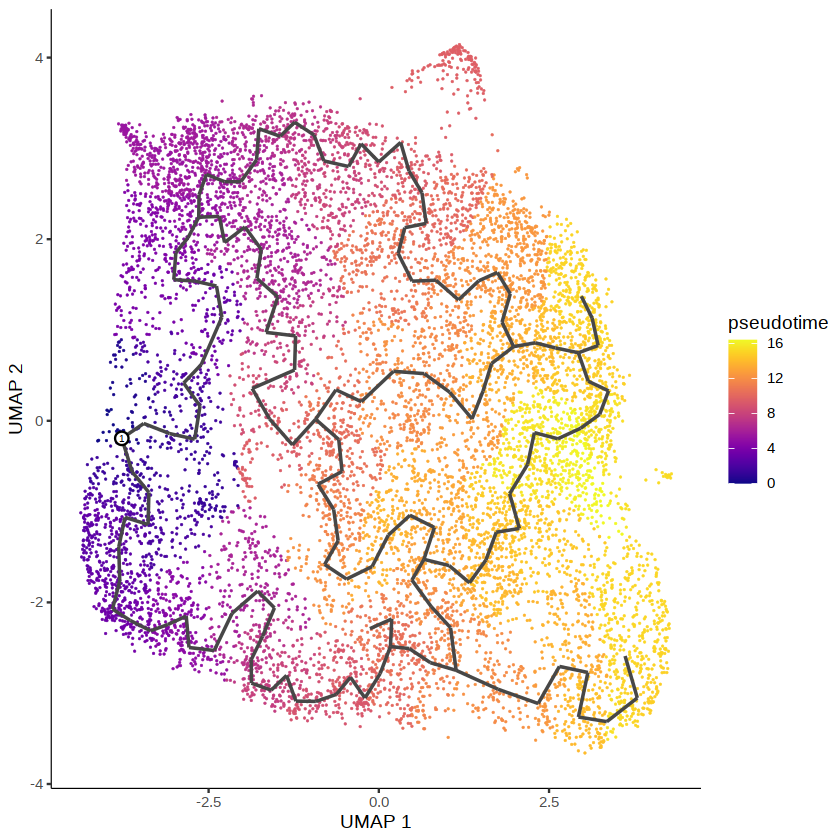

In [24]:
P3 <- plot_cells(cds, color_cells_by = "pseudotime", label_cell_groups = FALSE, 
    label_leaves = FALSE, label_branch_points = FALSE, graph_label_size = 2)
P3

# getting modulated genes

In [28]:
# get genes along pseudo time
modulated_genes <- graph_test1(cds, neighbor_graph = "principal_graph", cores = 8, verbose = FALSE) #use 'graph_test' if n_cells<10000


  |=======================================================| 100%, Elapsed 04:02
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"


In [29]:
saveRDS(modulated_genes, file="/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trajectory_with_Rik_model_output/allCD14_wave2_steroid_2021_modulated_genes.rds")

In [30]:
saveRDS(cds, file="/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trajectory_with_Rik_model_output/allCD14_wave2_steroid_2021_cds.rds")

# source code for graph_test1- use this if the number of cells is higher than 9999

In [27]:
#' Test genes for differential expression based on the low dimensional
#' embedding and the principal graph
#'
#' @description We are often interested in finding genes that are
#' differentially expressed across a single-cell trajectory. Monocle3
#' introduces a new approach for finding such genes that draws on a powerful
#' technique in spatial correlation analysis, the Moran’s I test. Moran’s I is
#' a measure of multi-directional and multi-dimensional spatial
#' autocorrelation. The statistic tells you whether cells at nearby positions
#' on a trajectory will have similar (or dissimilar) expression levels for the
#' gene being tested. Although both Pearson correlation and Moran’s I ranges
#' from -1 to 1, the interpretation of Moran’s I is slightly different: +1
#' means that nearby cells will have perfectly similar expression; 0 represents
#' no correlation, and -1 means that neighboring cells will be
#' *anti-correlated*.
#'
#' @param cds a cell_data_set object upon which to perform this operation
#' @param neighbor_graph String indicating what neighbor graph to use.
#'   "principal_graph" and "knn" are supported. Default is "knn", but
#'   "principal_graph" is recommended for trajectory analysis.
#' @param reduction_method character, the method used to reduce dimension.
#'   Currently only supported for "UMAP".
#' @param k Number of nearest neighbors used for building the kNN graph which
#'   is passed to knn2nb function during the Moran's I (Geary's C) test
#'   procedure.
#' @param method a character string specifying the method (currently only
#'   'Moran_I' is supported) for detecting significant genes showing
#'   correlation along the principal graph embedded in the low dimensional
#'   space.
#' @param alternative a character string specifying the alternative hypothesis,
#'   must be one of greater (default), less or two.sided.
#' @param expression_family a character string specifying the expression family
#'   function used for the test.
#' @param cores the number of cores to be used while testing each gene for
#'   differential expression.
#' @param verbose Whether to show spatial test (Moran's I) errors and warnings.
#'   Only valid for cores = 1.
#' @return a data frame containing the p values and q-values from the Moran's I
#'   test on the parallel arrays of models.
#' @seealso \code{\link[spdep]{moran.test}} \code{\link[spdep]{geary.test}}
#' @export
graph_test1 <- function(cds,
                       neighbor_graph = c("knn", "principal_graph"),
                       reduction_method = "UMAP",
                       k = 25,
                       method = c('Moran_I'),
                       alternative = 'greater',
                       expression_family="quasipoisson",
                       cores=1,
                       verbose=FALSE) {
  neighbor_graph <- match.arg(neighbor_graph)
  lw <- calculateLW(cds,
                    k = k,
                    verbose = verbose,
                    neighbor_graph = neighbor_graph,
                    reduction_method = reduction_method)

  if(verbose) {
    message("Performing Moran's I test: ...")
  }
  exprs_mat <- SingleCellExperiment::counts(cds)[, attr(lw, "region.id"), drop=FALSE]
  sz <- size_factors(cds)[attr(lw, "region.id")]

  wc <- spdep::spweights.constants(lw, zero.policy = TRUE, adjust.n = TRUE)
  test_res <- pbmcapply::pbmclapply(row.names(exprs_mat),
                                    FUN = function(x, sz, alternative,
                                                   method, expression_family) {
    exprs_val <- exprs_mat[x, ]

    if (expression_family %in% c("uninormal", "binomialff")){
      exprs_val <- exprs_val
    }else{
      exprs_val <- log10(exprs_val / sz + 0.1)
    }

    test_res <- tryCatch({
      if(method == "Moran_I") {
        mt <- suppressWarnings(my.moran.test(exprs_val, lw, wc, alternative = alternative))
        data.frame(status = 'OK', p_value = mt$p.value,
                   morans_test_statistic = mt$statistic,
                   morans_I = mt$estimate[["Moran I statistic"]])
      } else if(method == 'Geary_C') {
        gt <- suppressWarnings(my.geary.test(exprs_val, lw, wc, alternative = alternative))
        data.frame(status = 'OK', p_value = gt$p.value,
                   geary_test_statistic = gt$statistic,
                   geary_C = gt$estimate[["Geary C statistic"]])
      }
    },
    error = function(e) {
      data.frame(status = 'FAIL', p_value = NA, morans_test_statistic = NA,
                 morans_I = NA)
    })
  }, sz = sz, alternative = alternative, method = method,
  expression_family = expression_family, mc.cores=cores,
  ignore.interactive = TRUE)

  if(verbose) {
    message("returning results: ...")
  }
  
  test_res <- do.call(rbind.data.frame, test_res)
  
  row.names(test_res) <- row.names(cds)
  
  test_res <- merge(test_res, rowData(cds), by="row.names")
  
  #remove the first column and set the row names to the first column
  row.names(test_res) <- test_res[, 1]
  
  test_res[, 1] <- NULL
  test_res$q_value <- 1
  test_res$q_value[which(test_res$status == 'OK')] <-
    stats::p.adjust(subset(test_res, status == 'OK')[, 'p_value'], method="BH")
  test_res$status = as.character(test_res$status)
  # make sure gene name ordering in the DEG test result is the same as the CDS
  test_res[row.names(cds), ]
}


my.moran.test <- function (x, listw, wc, alternative = "greater",
                           randomisation = TRUE) {
  zero.policy = TRUE
  adjust.n = TRUE
  na.action = stats::na.fail
  drop.EI2 = FALSE
  xname <- deparse(substitute(x))
  wname <- deparse(substitute(listw))
  NAOK <- deparse(substitute(na.action)) == "na.pass"
  x <- na.action(x)
  na.act <- attr(x, "na.action")
  if (!is.null(na.act)) {
    subset <- !(1:length(listw$neighbours) %in% na.act)
    listw <- subset(listw, subset, zero.policy = zero.policy)
  }
  n <- length(listw$neighbours)
  if (n != length(x))
    stop("objects of different length")

  S02 <- wc$S0 * wc$S0
  res <- spdep::moran(x, listw, wc$n, wc$S0, zero.policy = zero.policy,
                      NAOK = NAOK)
  I <- res$I
  K <- res$K

  EI <- (-1)/wc$n1
  if (randomisation) {
    VI <- wc$n * (wc$S1 * (wc$nn - 3 * wc$n + 3) - wc$n *
                    wc$S2 + 3 * S02)
    tmp <- K * (wc$S1 * (wc$nn - wc$n) - 2 * wc$n * wc$S2 +
                  6 * S02)
    if (tmp > VI)
      warning(paste0("Kurtosis overflow,\ndistribution of variable does ",
                     "not meet test assumptions"))
    VI <- (VI - tmp)/(wc$n1 * wc$n2 * wc$n3 * S02)
    if (!drop.EI2)
      VI <- (VI - EI^2)
    if (VI < 0)
      warning(paste0("Negative variance,\ndistribution of variable does ",
                     "not meet test assumptions"))
  }
  else {
    VI <- (wc$nn * wc$S1 - wc$n * wc$S2 + 3 * S02)/(S02 *
                                                      (wc$nn - 1))
    if (!drop.EI2)
      VI <- (VI - EI^2)
    if (VI < 0)
      warning(paste0("Negative variance,\ndistribution of variable does ",
                     "not meet test assumptions"))
  }
  ZI <- (I - EI)/sqrt(VI)
  statistic <- ZI
  names(statistic) <- "Moran I statistic standard deviate"
  if (alternative == "two.sided")
    PrI <- 2 * stats::pnorm(abs(ZI), lower.tail = FALSE)
  else if (alternative == "greater")
    PrI <- stats::pnorm(ZI, lower.tail = FALSE)
  else PrI <- stats::pnorm(ZI)
  if (!is.finite(PrI) || PrI < 0 || PrI > 1)
    warning("Out-of-range p-value: reconsider test arguments")
  vec <- c(I, EI, VI)
  names(vec) <- c("Moran I statistic", "Expectation", "Variance")
  method <- paste("Moran I test under", ifelse(randomisation,
                                               "randomisation", "normality"))

  res <- list(statistic = statistic, p.value = PrI, estimate = vec)
  if (!is.null(na.act))
    attr(res, "na.action") <- na.act
  class(res) <- "htest"
  res
}

my.geary.test <- function (x, listw, wc, randomisation = TRUE,
                           alternative = "greater")
{
  zero.policy = TRUE
  adjust.n = TRUE
  spChk = NULL
  alternative <- match.arg(alternative, c("less", "greater",
                                          "two.sided"))
  if (!inherits(listw, "listw"))
    stop(paste(deparse(substitute(listw)), "is not a listw object"))
  if (!is.numeric(x))
    stop(paste(deparse(substitute(x)), "is not a numeric vector"))
  if (any(is.na(x)))
    stop("NA in X")
  n <- length(listw$neighbours)
  if (n != length(x))
    stop("objects of different length")
  if (is.null(spChk))
    spChk <- spdep::get.spChkOption()
  if (spChk && !spdep::chkIDs(x, listw))
    stop("Check of data and weights ID integrity failed")
  S02 <- wc$S0 * wc$S0
  res <- spdep::geary(x, listw, wc$n, wc$n1, wc$S0, zero.policy)
  C <- res$C
  if (is.na(C))
    stop("NAs generated in geary - check zero.policy")
  K <- res$K
  EC <- 1
  if (randomisation) {
    VC <- (wc$n1 * wc$S1 * (wc$nn - 3 * n + 3 - K * wc$n1))
    VC <- VC - ((1/4) * (wc$n1 * wc$S2 * (wc$nn + 3 * n -
                                            6 - K * (wc$nn - n + 2))))
    VC <- VC + (S02 * (wc$nn - 3 - K * (wc$n1^2)))
    VC <- VC/(n * wc$n2 * wc$n3 * S02)
  }
  else {
    VC <- ((2 * wc$S1 + wc$S2) * wc$n1 - 4 * S02)/(2 * (n +
                                                          1) * S02)
  }
  ZC <- (EC - C)/sqrt(VC)
  statistic <- ZC
  names(statistic) <- "Geary C statistic standard deviate"
  PrC <- NA
  if (is.finite(ZC)) {
    if (alternative == "two.sided")
      PrC <- 2 * stats::pnorm(abs(ZC), lower.tail = FALSE)
    else if (alternative == "greater")
      PrC <- stats::pnorm(ZC, lower.tail = FALSE)
    else PrC <- stats::pnorm(ZC)
    if (!is.finite(PrC) || PrC < 0 || PrC > 1)
      warning("Out-of-range p-value: reconsider test arguments")
  }
  vec <- c(C, EC, VC)
  names(vec) <- c("Geary C statistic", "Expectation", "Variance")
  method <- paste("Geary C test under", ifelse(randomisation,
                                               "randomisation", "normality"))
  data.name <- paste(deparse(substitute(x)), "\nweights:",
                     deparse(substitute(listw)), "\n")
  res <- list(statistic = statistic, p.value = PrC, estimate = vec,
              alternative = ifelse(alternative == "two.sided", alternative,
                                   paste("Expectation", alternative,
                                         "than statistic")),
              method = method, data.name = data.name)
  class(res) <- "htest"
  res
}

#' Function to calculate the neighbors list with spatial weights for the chosen
#' coding scheme from a cell dataset object
#'
#' @description This function first retrieves the association from each cell to
#' any principal points, then builds a kNN graph for all cells
#' and removes edges that connected between groups that disconnected in the
#' corresponding principal graph and finally uses this kNN graph to calculate a
#' global Moran's I and get the p-value
#' @param cds The cell_data_set object where the neighbors list is calculated
#'   from
#' @param  k The maximum number of nearest neighbors to compute
#' @param verbose A logic flag that determines whether or not to print
#' execution details
#' @keywords internal
#'
calculateLW <- function(cds,
                        k,
                        neighbor_graph,
                        reduction_method,
                        verbose = FALSE
) {
  if(verbose) {
    message("retrieve the matrices for Moran's I test...")
  }
  knn_res <- NULL
  principal_g <- NULL

  cell_coords <- reducedDims(cds)[[reduction_method]]
  if (neighbor_graph == "knn") {
    knn_res <- RANN::nn2(cell_coords, cell_coords,
                         min(k + 1, nrow(cell_coords)),
                         searchtype = "standard")[[1]]
  } else if(neighbor_graph == "principal_graph") {
    pr_graph_node_coords <- cds@principal_graph_aux[[reduction_method]]$dp_mst
    principal_g <-
      igraph::get.adjacency(
        cds@principal_graph[[reduction_method]])[colnames(pr_graph_node_coords),
                                                 colnames(pr_graph_node_coords)]
  }

  exprs_mat <- exprs(cds)
  if(neighbor_graph == "knn") {
    if(is.null(knn_res)) {
      knn_res <- RANN::nn2(cell_coords, cell_coords,
                           min(k + 1, nrow(cell_coords)),
                           searchtype = "standard")[[1]]
    }
    links <- monocle3:::jaccard_coeff(knn_res[, -1], F)
    links <- links[links[, 1] > 0, ]
    relations <- as.data.frame(links)
    colnames(relations) <- c("from", "to", "weight")
    knn_res_graph <- igraph::graph.data.frame(relations, directed = T)

      knn_list <- lapply(1:nrow(knn_res), function(x) knn_res[x, -1])
      region_id_names <- colnames(cds)

      id_map <- 1:ncol(cds)
      names(id_map) <- id_map

      points_selected <- 1:nrow(knn_res)

    knn_list <- lapply(points_selected,
                       function(x) id_map[as.character(knn_res[x, -1])])
  }
  else if (neighbor_graph == "principal_graph") {
    # mapping from each cell to the principal points
    cell2pp_map <-
      cds@principal_graph_aux[[
        reduction_method]]$pr_graph_cell_proj_closest_vertex
    if(is.null(cell2pp_map)) {
      stop(paste("Error: projection matrix for each cell to principal",
                 "points doesn't exist, you may need to rerun learn_graph"))
    }

    # This cds object might be a subset of the one on which ordering was
    # performed, so we may need to subset the nearest vertex and low-dim
    # coordinate matrices:
    cell2pp_map <-  cell2pp_map[row.names(cell2pp_map) %in%
                                  row.names(colData(cds)),, drop=FALSE]
    cell2pp_map <- cell2pp_map[colnames(cds), ]

    if(verbose) {
      message("Identify connecting principal point pairs ...")
    }
    # an alternative approach to make the kNN graph based on the principal
    # graph
    knn_res <- RANN::nn2(cell_coords, cell_coords,
                         min(k + 1, nrow(cell_coords)),
                         searchtype = "standard")[[1]]
    # convert the matrix of knn graph from the cell IDs into a matrix of
    # principal points IDs
    # kNN_res_pp_map <- matrix(cell2pp_map[knn_res], ncol = k + 1, byrow = F)

    # kNN can be built within group of cells corresponding to each principal
    # points
    principal_g_tmp <- principal_g
    diag(principal_g_tmp) <- 1 # so set diagnol as 1
    cell_membership <- as.factor(cell2pp_map)
    uniq_member <- sort(unique(cell_membership))

    membership_matrix <- Matrix::sparse.model.matrix( ~ cell_membership + 0)
    colnames(membership_matrix) <- levels(uniq_member)
    # sparse matrix multiplication for calculating the feasible space
    feasible_space <- membership_matrix %*%
      Matrix::tcrossprod(principal_g_tmp[as.numeric(levels(uniq_member)),
                                         as.numeric(levels(uniq_member))],
                         membership_matrix)

    links <- monocle3:::jaccard_coeff(knn_res[, -1], F)
    links <- links[links[, 1] > 0, ]
    relations <- as.data.frame(links)
    colnames(relations) <- c("from", "to", "weight")
    knn_res_graph <- igraph::graph.data.frame(relations, directed = T)

    # remove edges across cells belong to two disconnected principal points
    tmp_a <- igraph::get.adjacency(knn_res_graph)
    block_size <- 10000
    num_blocks = ceiling(nrow(tmp_a) / block_size)
    if(verbose) {
      message('start calculating valid kNN graph ...')
    }

    tmp <- NULL

    for (j in 1:num_blocks){
      if (j < num_blocks){
        block_a <- tmp_a[((((j-1) * block_size)+1):(j*block_size)), ]
        block_b <- feasible_space[((((j-1) * block_size)+1):(j*block_size)), ]
      }else{
        block_a <- tmp_a[((((j-1) * block_size)+1):(nrow(tmp_a))), ]
        block_b <- feasible_space[((((j-1) * block_size)+1):(nrow(tmp_a))), ]
      }

      cur_tmp <- block_a * block_b

      if(is.null(tmp)) {
        tmp <- cur_tmp
      } else {
        tmp <- rbind(tmp, cur_tmp)
      }
    }

    #close(pb_feasible_knn)
    if(verbose) {
      message('Calculating valid kNN graph, done ...')
    }

      region_id_names <- colnames(cds)

      id_map <- 1:ncol(cds)
      names(id_map) <- id_map

    knn_list <-
      slam::rowapply_simple_triplet_matrix(slam::as.simple_triplet_matrix(tmp),
                                           function(x) {
                                             res <- which(as.numeric(x) > 0)
                                             if(length(res) == 0)
                                               res <- 0L
                                             res
                                           })
  } else {
    stop("Error: unrecognized neighbor_graph option")
  }
  # create the lw list for moran.test
  names(knn_list) <- id_map[names(knn_list)]
  class(knn_list) <- "nb"
  attr(knn_list, "region.id") <- region_id_names
  attr(knn_list, "call") <- match.call()
  # attr(knn_list, "type") <- "queen"
  lw <- spdep::nb2listw(knn_list, zero.policy = TRUE)
  lw
}